In [25]:
from astral import LocationInfo
import pytz
import sys
import pandas as pd
import numpy as np
from dotenv import load_dotenv

sys.path.append('/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting')

from neuro_symbolic_demand_forecasting.encoders.encoders import PartOfDayEncoder, encode_is_holiday

from darts.timeseries import TimeSeries
from scipy.constants import convert_temperature

from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
%autoreload

In [16]:
AMS_TZ = pytz.timezone('Europe/Amsterdam')

city = LocationInfo("Amsterdam", "Netherlands", "Europe/Amsterdam")
part_of_day_encoder = PartOfDayEncoder(city, AMS_TZ)

In [78]:
pv_05 = pd.read_csv('../data/2023_05_cleaned_pv.csv', parse_dates=True).set_index('readingdate')
non_pv_05 = pd.read_csv('../data/2023_05_cleaned_non_pv.csv', parse_dates=True).set_index('readingdate')

pv_06 = pd.read_csv('../data/2023_06_cleaned_pv.csv', parse_dates=True).set_index('readingdate')
non_pv_06 = pd.read_csv('../data/2023_06_cleaned_non_pv.csv', parse_dates=True).set_index('readingdate')

pv_07 = pd.read_csv('../data/2023_07_cleaned_pv.csv', parse_dates=True).set_index('readingdate')
non_pv_07 = pd.read_csv('../data/2023_07_cleaned_non_pv.csv', parse_dates=True).set_index('readingdate')

pv_05.index = pd.to_datetime(pv_05.index)
non_pv_05.index = pd.to_datetime(non_pv_05.index)
pv_06.index = pd.to_datetime(pv_06.index)
non_pv_06.index = pd.to_datetime(non_pv_06.index)
pv_07.index = pd.to_datetime(pv_07.index)
non_pv_07.index = pd.to_datetime(non_pv_07.index)


pv05_ts = TimeSeries.from_dataframe(pv_05)
non_pv05_ts = TimeSeries.from_dataframe(non_pv_05)
pv06_ts = TimeSeries.from_dataframe(pv_06)
non_pv06_ts = TimeSeries.from_dataframe(non_pv_06)
pv07_ts = TimeSeries.from_dataframe(pv_07)
non_pv07_ts = TimeSeries.from_dataframe(non_pv_07)

actuals_df = pd.read_csv('../data/2023-04_to_08-amsterdam-actuals_filled_gaps.csv', parse_dates=['datetime_from']).set_index('datetime_from')[[ 'wind_speed', 'global_radiation', 'air_pressure', 'air_temperature', 'relative_humidity' ]]
actuals_df = actuals_df.resample('15min').mean()
actuals_df['temperature_c'] = actuals_df['air_temperature'].apply(lambda x: convert_temperature(x, 'K', 'C'))
actuals_df = TimeSeries.from_dataframe(actuals_df, freq='15min')

forecasts_df = pd.read_csv('../data/2023_weather_data_06_run_summer_from_04_to_08.csv', parse_dates=['valid_datetime']).set_index('valid_datetime')[[ 'wind_speed_10m', 'grad_accum_ground_0m', 'pres_instant_ground_0m', 't_instant_ground_2m', 'r_instant_ground_2m' ]]
forecasts_df = forecasts_df.resample('15min').ffill()
forecasts_df = TimeSeries.from_dataframe(forecasts_df,freq='15min')

# prices = pd.read_csv('../data/2023-04_to_08_prices.csv', parse_dates=['DELIVERY_DATETIME']).set_index('DELIVERY_DATETIME')
# prices.index = prices.index.tz_convert(pytz.timezone('Europe/Amsterdam')).tz_localize(None)
# prices = TimeSeries.from_dataframe(prices, freq='15min')
# prices = prices[val_df.time_index.min():val_df.time_index.max()]

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the 

<Axes: xlabel='readingdate'>

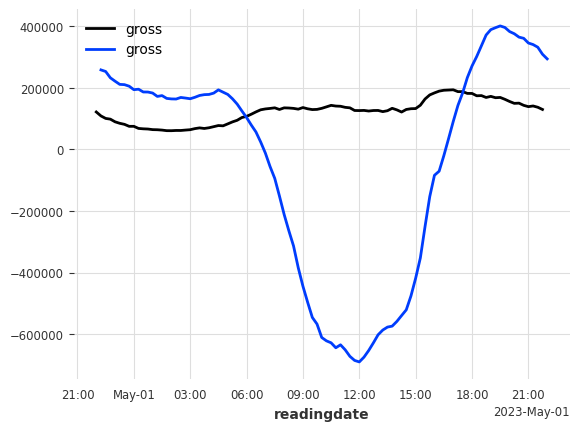

In [20]:
non_pv05_ts[0:96].plot()
pv05_ts[0:96].plot()
# non_pv06_ts[0:96].plot(new_plot=True)
# non_pv07_ts[0:96].plot(new_plot=True)

## Checking that thresholds of holidays and part of day match visually

/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.11/lib/python3.11/site-packages/darts/timeseries.py:4033: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


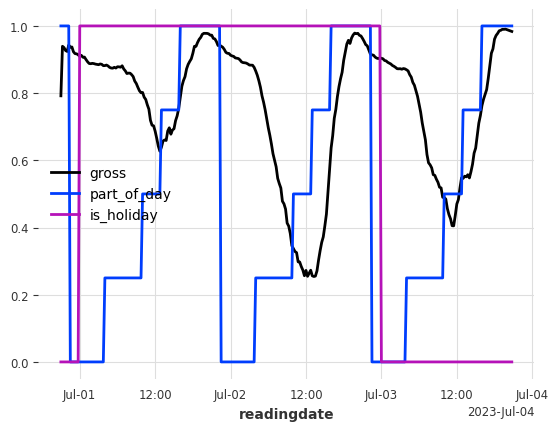

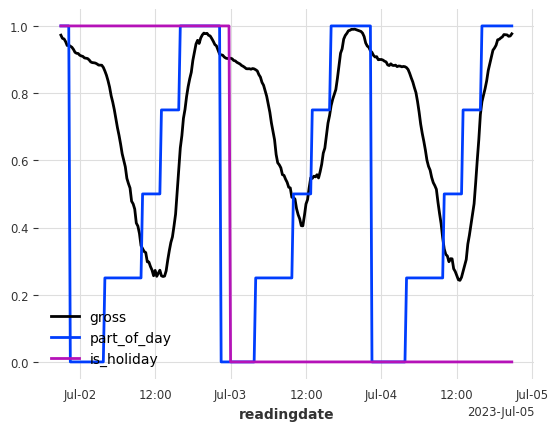

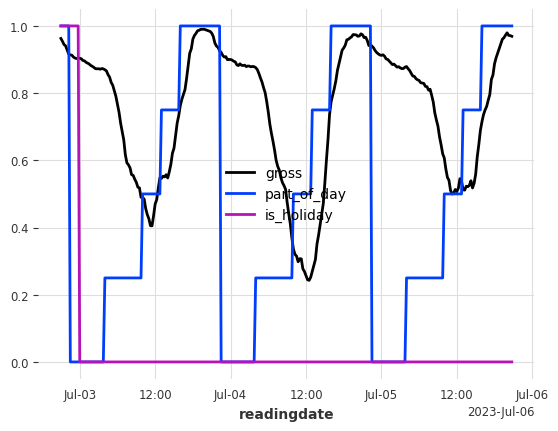

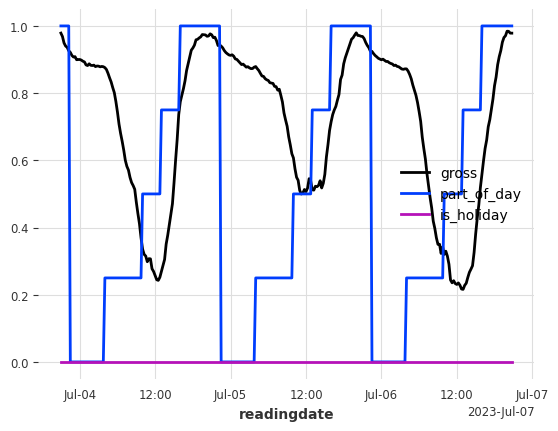

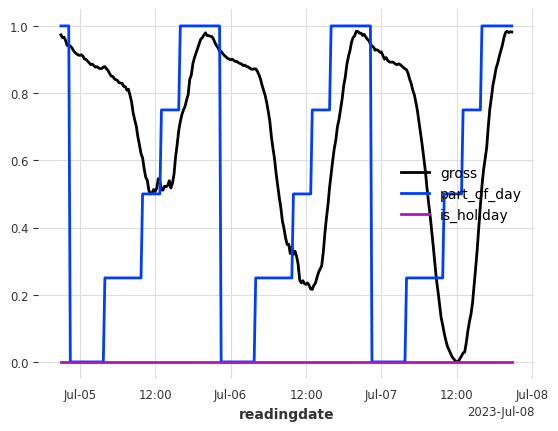

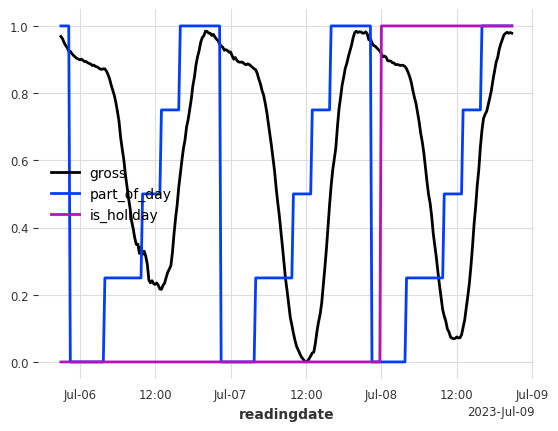

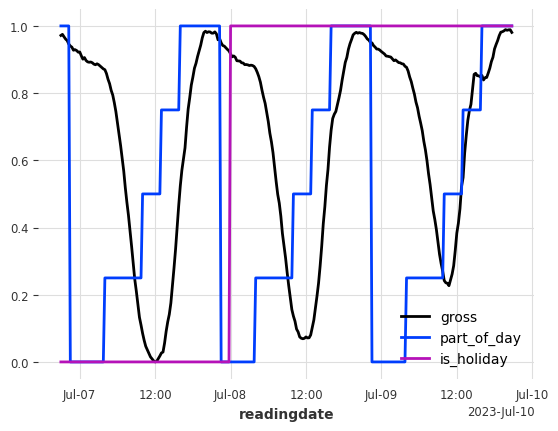

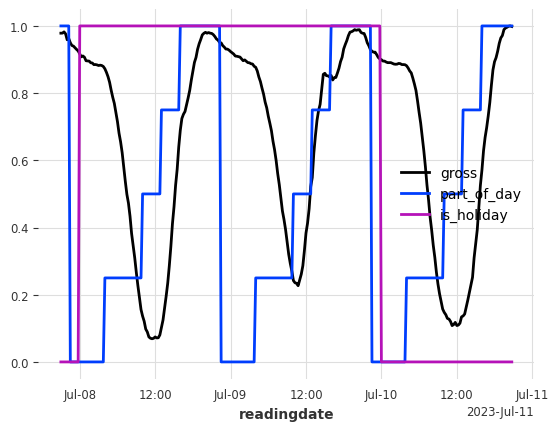

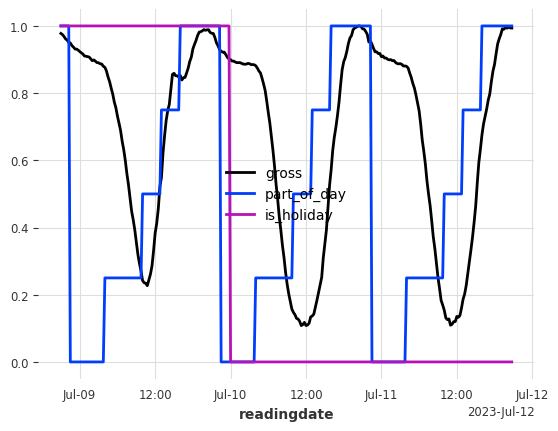

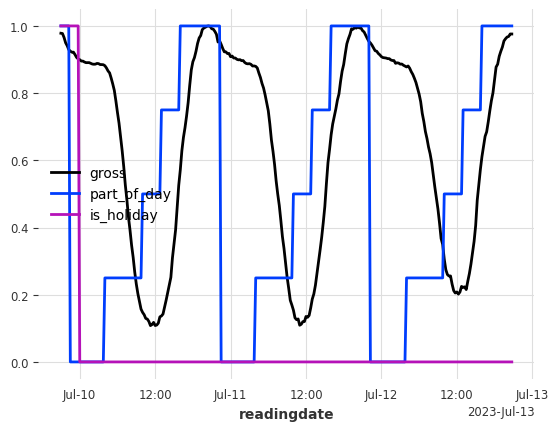

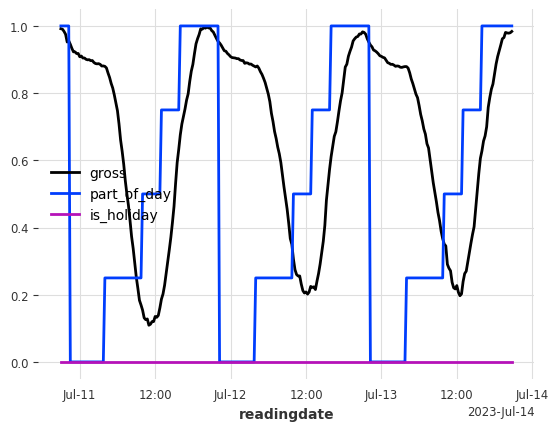

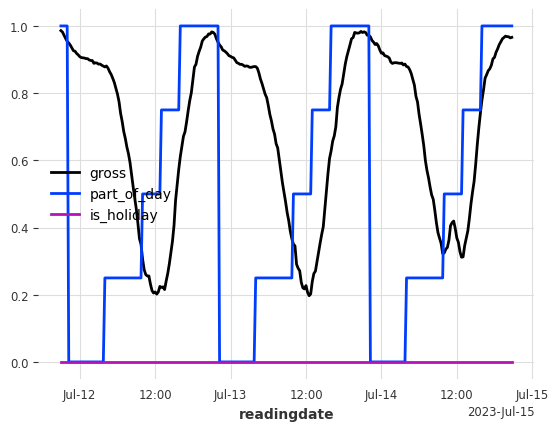

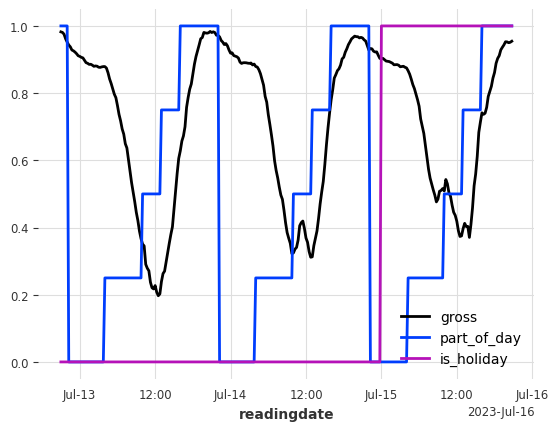

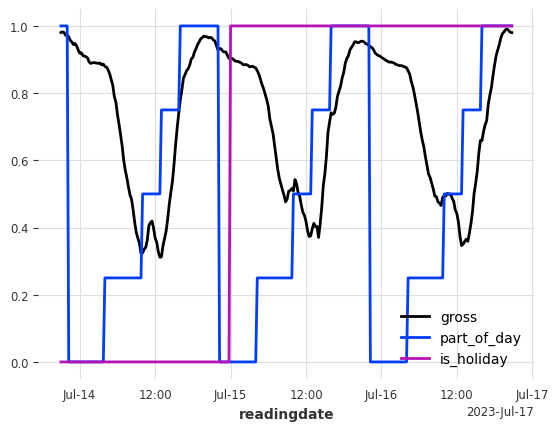

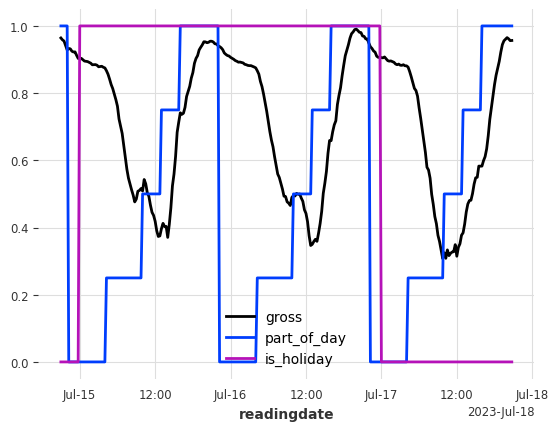

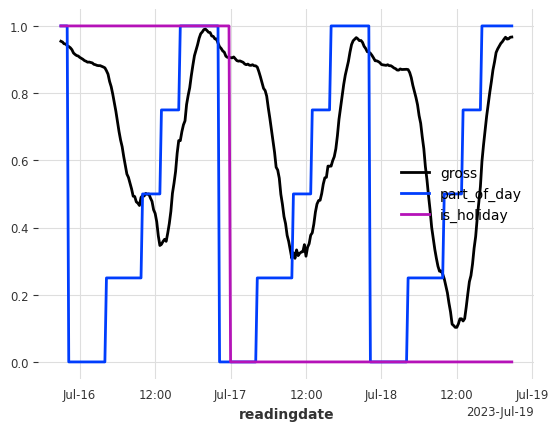

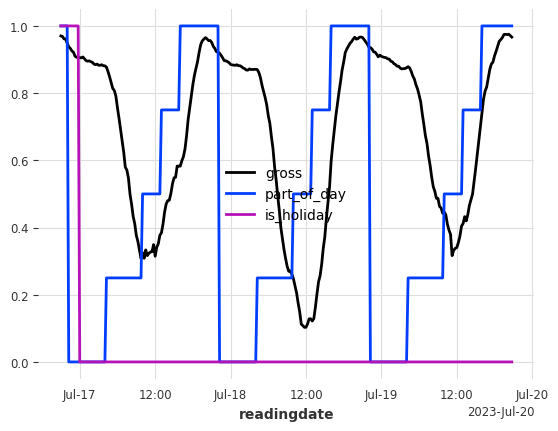

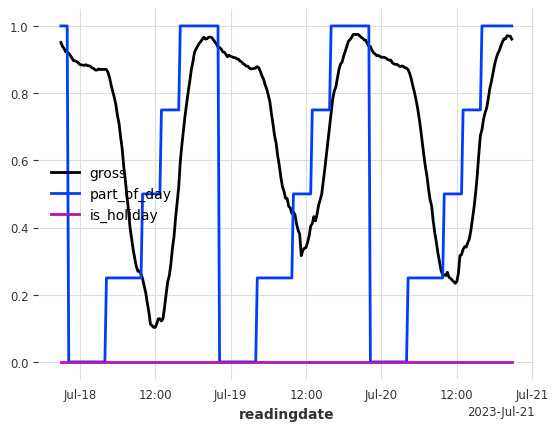

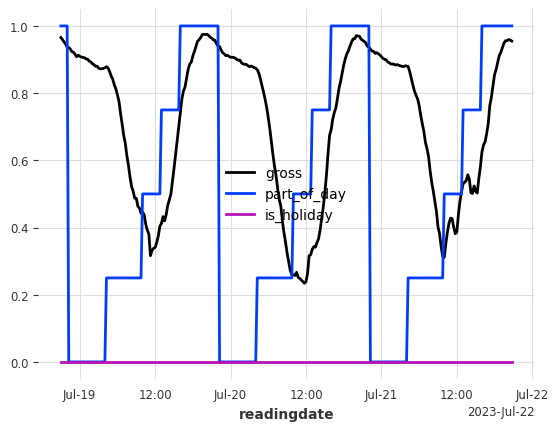

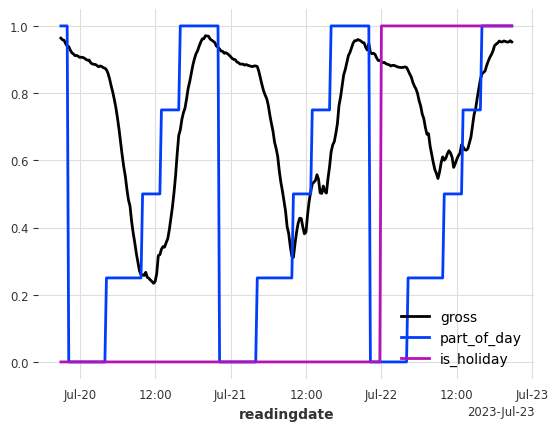

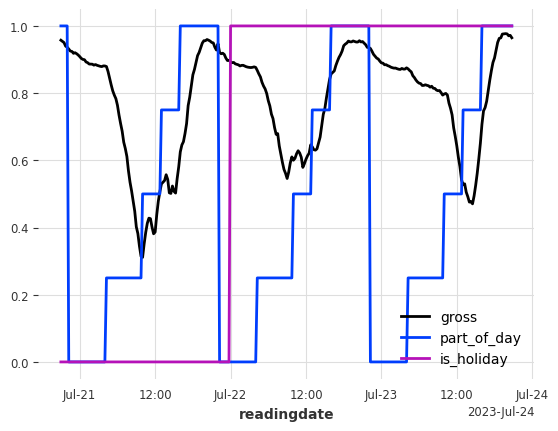

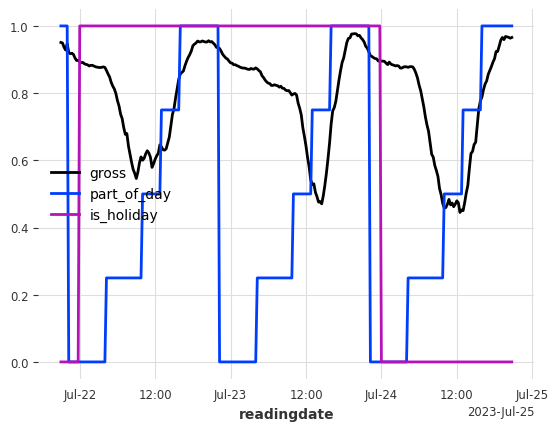

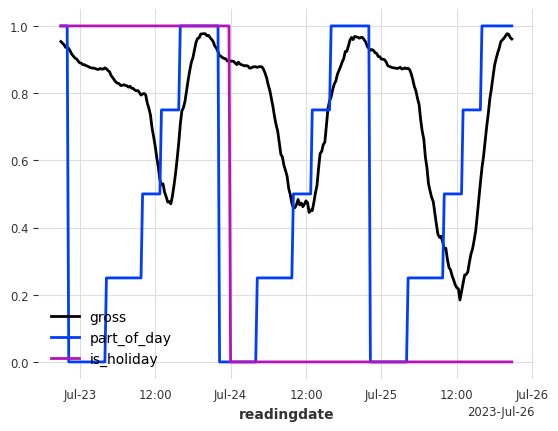

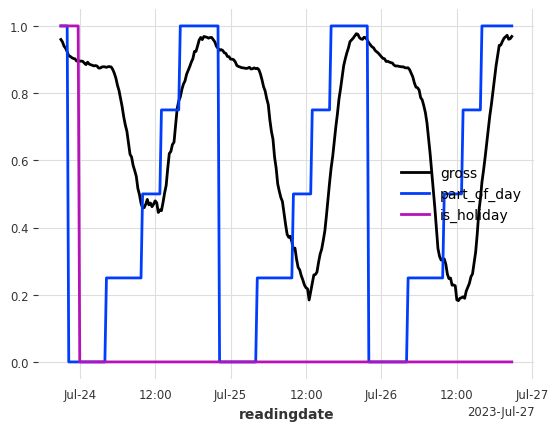

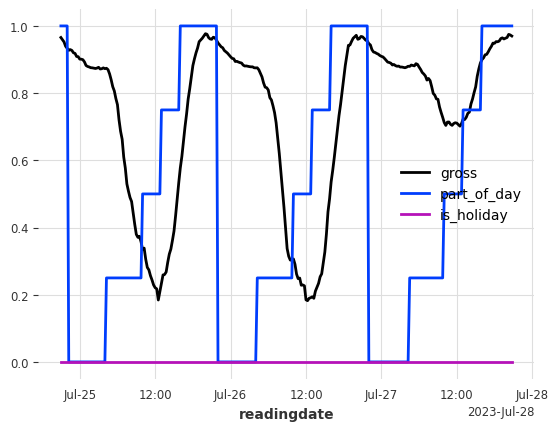

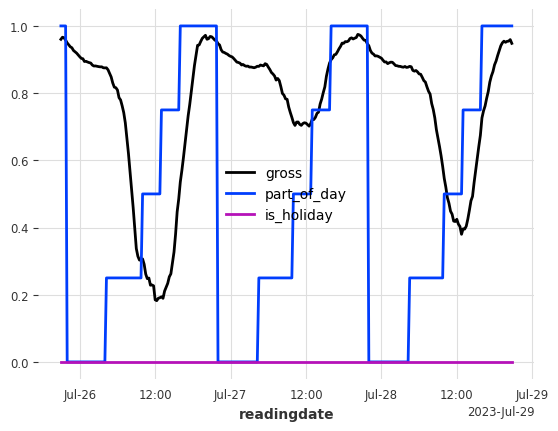

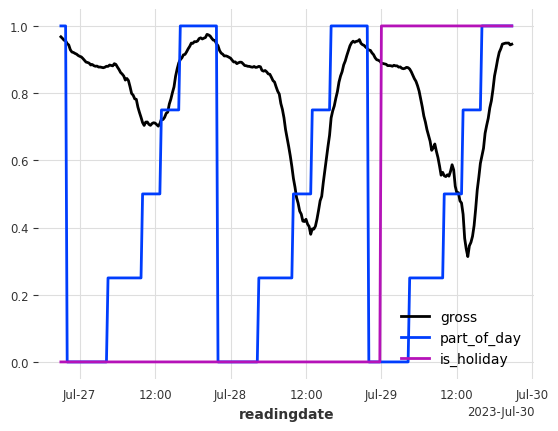

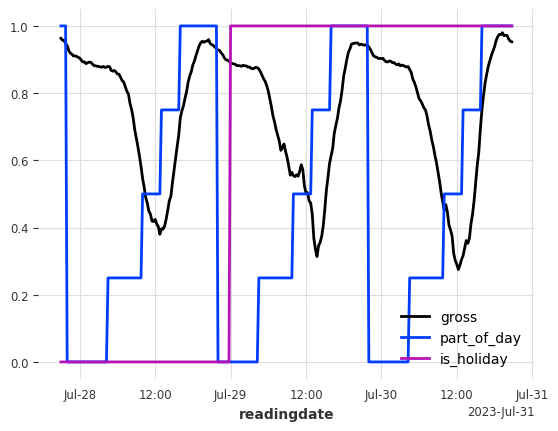

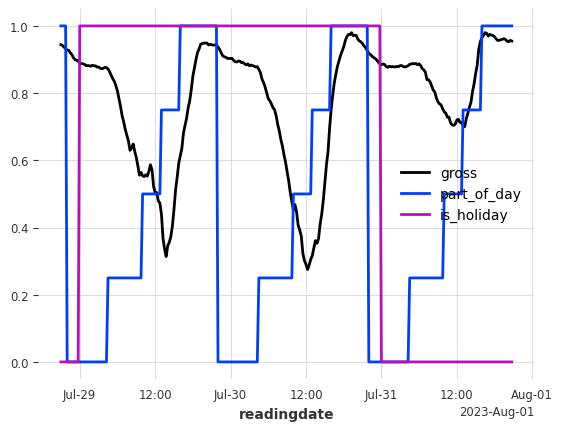

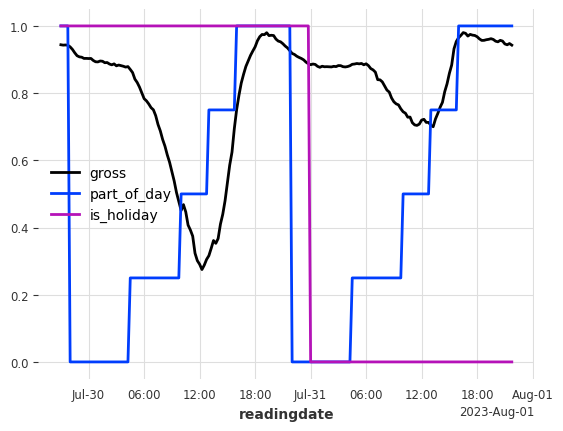

In [44]:
# pv05_ts.stack()
# ts = non_pv05_ts
ts = pv07_ts
scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
# scaler = Scaler(MinMaxScaler(feature_range=(-1, 1)))

scaled_ts = scaler.fit_transform(ts)
pod = TimeSeries.from_times_and_values(times=ts.time_index, values=part_of_day_encoder.encode(ts.time_index), columns=['part_of_day'])
hol = TimeSeries.from_times_and_values(times=ts.time_index, values=encode_is_holiday(ts.time_index), columns=['is_holiday'])

scaled_ts = scaled_ts.stack(pod).stack(hol)
step = 3
for i in range(0,30, 1):
    scaled_ts[i*96:(i+step)*96].plot(new_plot=True)

## Checking that temperature threshold match expectations

In [45]:
ts = pv07_ts
subset_weather = actuals_df[ts.time_index.min():ts.time_index.max()]

In [ ]:
hol = TimeSeries.from_times_and_values(times=ts.time_index, values=encode_is_holiday(ts.time_index), columns=['is_holiday'])


In [74]:
scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
# scaler = Scaler(MinMaxScaler(feature_range=(-1, 1)))

scaled_ts = scaler.fit_transform(ts)
subset_weather: TimeSeries = subset_weather[['temperature_c', 'relative_humidity']]
scaled_weather = scaler.fit_transform(subset_weather)


In [73]:
subset_weather.filter(subset_weather['temperature_c'] > 26)
subset_weather.

AttributeError: 'TimeSeries' object has no attribute 'filter'

<Axes: xlabel='datetime_from'>

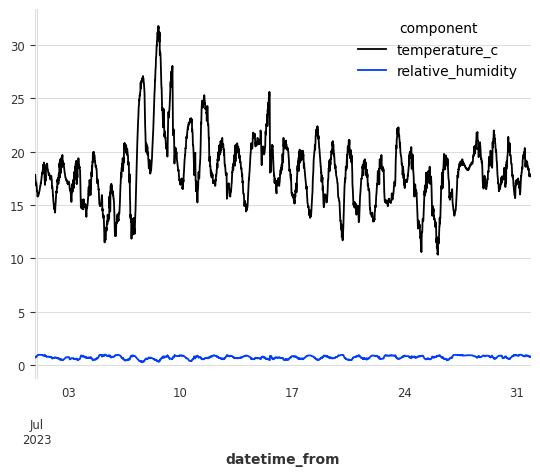

In [70]:
subset_df = subset_weather.pd_dataframe()
subset_df['is_hot'] = (subset_df['temperature_c'] > 26) & (subset_df['relative_humidity'] > 0.55)

<Axes: xlabel='datetime_from'>

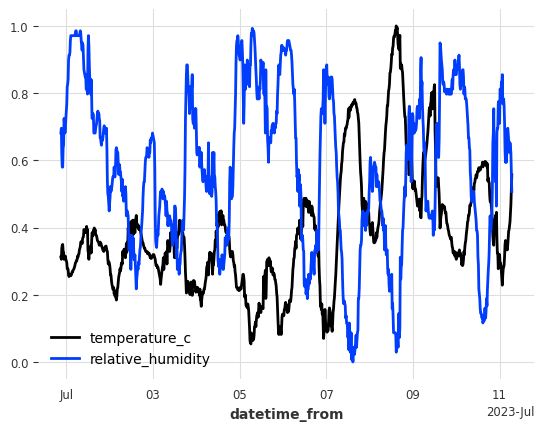

In [58]:
scaled_weather[0:1000].plot()

## Loss Curves

In [75]:
import pandas as pd

l = pd.read_csv('/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/20240606_1356_full_tft_training_baseline/train_losses.csv')

<Axes: xlabel='batch'>

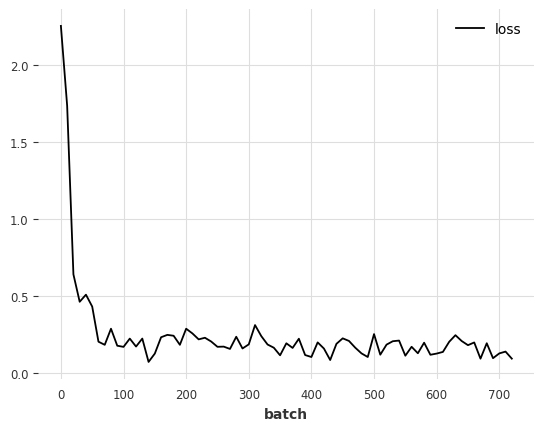

In [77]:
l.set_index('batch').plot()

## Evaluation with Test Set

First run main_predict with the model you wish to evaluate

In [ ]:
import matplotlib.pyplot as plt

full_ts = ts_semantic.stack(ts_baseline['gross_predicted'].with_columns_renamed('gross_predicted', 'baseline')).with_columns_renamed(['gross_actuals','gross_predicted'], ['target', 'semantic'])
ax = full_ts[0:672].plot()
ax.set_ylabel('Consumption in Wh')
ax.set_xlabel('Time')

### Loading data

In [ ]:

pv_07 = pd.read_csv('../data/2023_07_cleaned_pv.csv', parse_dates=True).set_index('readingdate')
non_pv_07 = pd.read_csv('../data/2023_07_cleaned_non_pv.csv', parse_dates=True).set_index('readingdate')

pv_07.index = pd.to_datetime(pv_07.index)
non_pv_07.index = pd.to_datetime(non_pv_07.index)

pv07_ts = TimeSeries.from_dataframe(pv_07)
non_pv07_ts = TimeSeries.from_dataframe(non_pv_07)

actuals_df = pd.read_csv('../data/2023-04_to_08-amsterdam-actuals_filled_gaps.csv', parse_dates=['datetime_from']).set_index('datetime_from')[[ 'wind_speed', 'global_radiation', 'air_pressure', 'air_temperature', 'relative_humidity' ]]
actuals_df = actuals_df.resample('15min').mean()
# actuals_df['temperature_c'] = actuals_df['air_temperature'].apply(lambda x: convert_temperature(x, 'K', 'C'))
actuals_df = TimeSeries.from_dataframe(actuals_df, freq='15min')

forecasts_df = pd.read_csv('../data/2023_weather_data_06_run_summer_from_04_to_08.csv', parse_dates=['valid_datetime']).set_index('valid_datetime')[[ 'wind_speed_10m', 'grad_accum_ground_0m', 'pres_instant_ground_0m', 't_instant_ground_2m', 'r_instant_ground_2m' ]]
forecasts_df = forecasts_df.resample('15min').ffill()
forecasts_df = TimeSeries.from_dataframe(forecasts_df,freq='15min')